In [3]:
########## Calling relevant libraries ##########
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import mean_squared_error

import scipy, sqlite3, h5py

import pandas as pd

import sklearn
import sklearn.model_selection as model_selection
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import BaggingRegressor

import rampy as rp

import sys
sys.path.append("/home/charles/GoogleDrive/viscopy/")
sys.path.append("/home/charles/GoogleDrive/structupy/")
import viscopy as vp
import structupy as spy

In [4]:
# # FULL DATASET
# con = sqlite3.connect('./data/viscosity.sqlite')

# dataset = pd.read_sql_query("SELECT * from viscosity", con)
# con.close() # closing the sql connection



In [5]:
# KNAS, comment to deactivate
dataset = pd.read_excel("./data/Database_IPGP.xlsx")
print(dataset.columns)

dataset = vp.chimie_control(dataset)
ap, b = vp.heatcp(dataset,Cp_glass = "3R")
n_b_o = spy.nbot(dataset)
ionicfs = spy.ifs(dataset)
atoms_ = spy.atoms(dataset)

K32 = spy.kcalc(atoms_,ionicfs,Al_effect=True)

q1, q2, q3, q4 = spy.qnbo(K32['Q3'],K32['Q2'],n_b_o["nbot"])

print(n_b_o.columns)
print(ionicfs.columns)

dataset['ap'] = ap
dataset['b'] = b
dataset['nbot'] = n_b_o['nbot']
dataset['ifsm'] = ionicfs['ifsm']
dataset['ifst'] = ionicfs['ifst']#.fillna(0.0)

dataset['q1'] = q1
dataset['q2'] = q2
dataset['q3'] = q3
dataset['q4'] = q4

dataset['ScT'] = dataset['Sc'] + ap*(np.log(dataset['T'])-np.log(dataset['tg'])) + b*(dataset['T']-dataset['tg'])

Index(['Name', 'sio2', 'al2o3', 'fe2o3', 'h2o', 'na2o', 'k2o', 'mgo', 'cao',
       'feo', 'tg', 'T', 'viscosity', 'ref', 'color', 'Sc'],
      dtype='object')
Index(['nbot', 't', 'o', 'm'], dtype='object')
Index(['ifsm', 'ifst', 'difst', 'ifsmr', 'ifstr'], dtype='object')


/home/charles/GoogleDrive/structupy/structupy/structure.py:263: RuntimeWarning: invalid value encountered in sqrt
  q3[n <= bk] = (-b - np.sqrt(b**2 - 4*a[n <= bk]*c[n <= bk]))/(2.0*a[n <= bk])
/home/charles/GoogleDrive/structupy/structupy/structure.py:266: RuntimeWarning: invalid value encountered in sqrt
  q4 = 1.0-(n - (-b - np.sqrt(b**2 - 4.0*a*c))/(2.0*a))/2.0 -(-b - np.sqrt(b**2 - 4.0*a*c))/(2.0*a)
/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:29: RuntimeWarning: divide by zero encountered in log


In [6]:
# train-valid-test split
tv_sub, test_sub, idxtv_sub, idxtest_sub = rp.chemical_splitting(dataset,'Name',0.15, rand_state=81)
train_sub, valid_sub, idxtrain_sub, idxvalid_sub = rp.chemical_splitting(tv_sub,'Name',0.10, rand_state=81)

# For entropy
train_entropy = train_sub.dropna(subset=['Sc'])
valid_entropy = valid_sub.dropna(subset=['Sc'])
test_entropy = test_sub.dropna(subset=['Sc'])

# Now we need to fillna in other datasets
train_sub = train_sub.fillna(0.0)
valid_sub = valid_sub.fillna(0.0)
test_sub = test_sub.fillna(0.0)

# Viscosity train-valid-test splits
y_train = train_sub["viscosity"].values.reshape(-1,1)
y_valid = valid_sub["viscosity"].values.reshape(-1,1)
y_tv = tv_sub["viscosity"].values.reshape(-1,1)
y_test = test_sub["viscosity"].values.reshape(-1,1)

# FOR KNAS : CHOICE
X_columns = ["sio2","al2o3","na2o","k2o","nbot","ifsm","ifst","ap","b","T","Sc","tg","ScT"]
# For all data, select "sio2":"T"

X_train = train_sub.loc[:,X_columns].values
X_valid = valid_sub.loc[:,X_columns].values
X_tv = tv_sub.loc[:,X_columns].values
X_test = test_sub.loc[:,X_columns].values

X_entropy_train = train_entropy.loc[:,X_columns].values
X_entropy_valid = valid_entropy.loc[:,X_columns].values
X_entropy_test = test_entropy.loc[:,X_columns].values

print("X training and validation set shape, unscaled")
print(X_train.shape)
#print(X_train_sc.shape)

print("X valid set shape, unscaled")
print(X_valid.shape)
#print(X_valid_sc.shape)

print("X test set shape, unscaled")
print(X_test.shape)
#print(X_test_sc.shape)

print("\nEntropy training shape, unscaled")
print(train_entropy.shape)

print("Entropy validation shape, unscaled")
print(valid_entropy.shape)

print("Entropy testing shape, unscaled")
print(test_entropy.shape)

X training and validation set shape, unscaled
(1047, 13)
X valid set shape, unscaled
(98, 13)
X test set shape, unscaled
(203, 13)

Entropy training shape, unscaled
(528, 32)
Entropy validation shape, unscaled
(79, 32)
Entropy testing shape, unscaled
(89, 32)


In [7]:
# parameters for neural net
prm_nn = dict(hidden_layer_sizes=(100,),solver = 'lbfgs',activation='relu',early_stopping=True)
param_b = dict(n_estimators=30, max_samples=1.0, max_features=1.0, bootstrap=True, bootstrap_features=False, oob_score=False, warm_start=False, n_jobs=1, verbose=0)

model = rp.mlregressor(X_train,y_train,algorithm="BaggingNeuralNet"
                        , scaler = "StandardScaler",X_test = X_valid, y_test = y_valid,
                       param_neurons=prm_nn,param_bagging=param_b,rand_state=100)

model.fit()
# we grab the scaling from rp.mlregressor

In [8]:
X_entropy_train_sc = model.X_scaler.transform(X_entropy_train)
X_entropy_valid_sc = model.X_scaler.transform(X_entropy_valid)
X_entropy_test_sc = model.X_scaler.transform(X_entropy_test)

X_tv_sc = model.X_scaler.transform(X_tv)

X_train_sc = model.X_scaler.transform(X_train)
y_train_sc = model.Y_scaler.transform(y_train.reshape(-1,1))

X_valid_sc = model.X_scaler.transform(X_valid)
y_valid_sc = model.Y_scaler.transform(y_valid.reshape(-1,1))

X_test_sc = model.X_scaler.transform(X_test)
y_test_sc = model.Y_scaler.transform(y_test.reshape(-1,1))

# we ensure that only the chemistry was standardized
X_train_sc[:,7:] = X_train[:,7:]
X_valid_sc[:,7:] = X_valid[:,7:]
X_test_sc[:,7:] = X_test[:,7:]
X_tv_sc[:,7:] = X_tv[:,7:]

X_entropy_train_sc[:,7:] = X_entropy_train[:,7:]
X_entropy_valid_sc[:,7:] = X_entropy_valid[:,7:]
X_entropy_test_sc[:,7:] = X_entropy_test[:,7:]

In [9]:
MSE_NN_train = np.sqrt(mean_squared_error(model.y_train, model.prediction_train))
MSE_NN_valid = np.sqrt(mean_squared_error(model.y_test, model.prediction_test))
MSE_NN_test = np.sqrt(mean_squared_error(y_test, model.predict(X_test)))

print("training and testing RMSE with neural nets")
print(MSE_NN_train)
print(MSE_NN_valid)
print(MSE_NN_test)


training and testing RMSE with neural nets
0.09136713976330363
0.47769075294013563
0.39459777429483317


/home/charles/miniconda3/envs/py36/lib/python3.6/site-packages/matplotlib/figure.py:98: MatplotlibDeprecationWarning: 
Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  "Adding an axes using the same arguments as a previous axes "


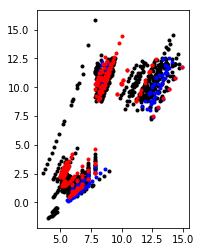

In [10]:
plt.subplot(121)
plt.plot(10000/X_train[:,9],y_train,"k.")

plt.subplot(121)
plt.plot(10000/X_valid[:,9],y_valid,"b.")

plt.subplot(121)
plt.plot(10000/X_test[:,9],y_test,"r.")

In [11]:
with h5py.File('./data/DataSet.hdf5', 'w') as f:
    f.create_dataset('X_columns', data=np.array(X_columns, dtype="S10"))
    
    f.create_dataset('X_entropy_train', data=X_entropy_train)
    f.create_dataset('X_entropy_train_sc', data=X_entropy_train_sc)
    
    f.create_dataset('X_entropy_valid', data=X_entropy_valid)
    f.create_dataset('X_entropy_valid_sc', data=X_entropy_valid_sc)
    
    f.create_dataset('X_entropy_test', data=X_entropy_test)
    f.create_dataset('X_entropy_test_sc', data=X_entropy_test_sc)
    
    f.create_dataset('X_tv', data=X_tv)
    f.create_dataset('X_tv_sc', data=X_tv_sc)
    f.create_dataset('y_tv', data=y_tv)
    
    f.create_dataset('X_train', data=X_train)
    f.create_dataset('X_train_sc', data=X_train_sc)
    
    f.create_dataset('y_train', data=y_train)
    f.create_dataset('y_train_sc', data=y_train_sc)
    
    f.create_dataset('X_valid', data=X_valid)
    f.create_dataset('X_valid_sc', data=X_valid_sc)
    
    f.create_dataset('y_valid', data=y_valid)
    f.create_dataset('y_valid_sc', data=y_valid_sc)
    
    f.create_dataset('X_test', data=X_test)
    f.create_dataset('X_test_sc', data=X_test_sc)
    
    f.create_dataset('y_test', data=y_test)
    f.create_dataset('y_test_sc', data=y_test_sc)
    
    f.create_dataset('X_scaler_mean', data=model.X_scaler.mean_)
    f.create_dataset('X_scaler_var', data=model.X_scaler.var_)
    
    f.create_dataset('y_scaler_mean', data=model.Y_scaler.mean_)
    f.create_dataset('y_scaler_var', data=model.Y_scaler.var_)

    

In [15]:
print(X_train.shape)
print(X_valid.shape)
print(X_test.shape)

(1047, 13)
(98, 13)
(203, 13)


# Artificial, for final plots

# For Na-K in NKS3

In [10]:
dataset_arti = pd.DataFrame()

k2o = np.arange(0,0.25,0.01)

dataset_arti["sio2"] = np.ones(len(k2o))*0.75
dataset_arti["al2o3"] = 0.0
dataset_arti["na2o"] = 0.25 - k2o
dataset_arti["k2o"] = k2o

dataset_arti = vp.chimie_control(dataset_arti)
ap_arti, b_arti = vp.heatcp(dataset_arti,Cp_glass="3R")
n_b_o_arti = spy.nbot(dataset_arti)
ionicfs_arti = spy.ifs(dataset_arti)

dataset_arti['nbot'] = n_b_o['nbot']
dataset_arti['ifsm'] = ionicfs_arti['ifsm']
dataset_arti['ifst'] = ionicfs_arti['ifst']#.fillna(0.0)

dataset_arti['ap'] = ap_arti
dataset_arti['b'] = b_arti
dataset_arti['T'] = np.ones(len(k2o))*1000.0

X_arti_NKS = dataset_arti.loc[:,X_columns].values

X_arti_NKS[:,0:7] = model.X_scaler.transform(X_arti_NKS)[:,0:7]

/Users/charles/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


# For NS

In [11]:
dataset_arti = pd.DataFrame()

sio2 = np.arange(0.6,1.,0.01)

dataset_arti["sio2"] = sio2
dataset_arti["al2o3"] = 0.0
dataset_arti["na2o"] = 0.25
dataset_arti["k2o"] = 0.

dataset_arti = vp.chimie_control(dataset_arti)
ap_arti, b_arti = vp.heatcp(dataset_arti,Cp_glass="3R")
n_b_o_arti = spy.nbot(dataset_arti)
ionicfs_arti = spy.ifs(dataset_arti)

dataset_arti['nbot'] = n_b_o['nbot']
dataset_arti['ifsm'] = ionicfs_arti['ifsm']
dataset_arti['ifst'] = ionicfs_arti['ifst']#.fillna(0.0)

dataset_arti['ap'] = ap_arti
dataset_arti['b'] = b_arti
dataset_arti['T'] = np.ones(len(sio2))*1000.0

X_arti_NS = dataset_arti.loc[:,X_columns].values

X_arti_NS[:,0:7] = model.X_scaler.transform(X_arti_NS)[:,0:7]



/Users/charles/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [15]:
dataset_arti = pd.DataFrame()

vari = np.arange(0.,0.30,0.01)

dataset_arti["sio2"] = np.ones(len(vari))*0.66
dataset_arti["al2o3"] = vari
dataset_arti["na2o"] = 0.34-vari
dataset_arti["k2o"] = 0.

dataset_arti = vp.chimie_control(dataset_arti)
ap_arti, b_arti = vp.heatcp(dataset_arti,Cp_glass="3R")
n_b_o_arti = spy.nbot(dataset_arti)
ionicfs_arti = spy.ifs(dataset_arti)

dataset_arti['nbot'] = n_b_o['nbot']
dataset_arti['ifsm'] = ionicfs_arti['ifsm']
dataset_arti['ifst'] = ionicfs_arti['ifst']#.fillna(0.0)

dataset_arti['ap'] = ap_arti
dataset_arti['b'] = b_arti
dataset_arti['T'] = np.ones(len(vari))*1000.0

X_arti_NAS = dataset_arti.loc[:,X_columns].values

X_arti_NAS[:,0:7] = model.X_scaler.transform(X_arti_NAS)[:,0:7]



/Users/charles/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [16]:
dataset_arti = pd.DataFrame()

vari = np.arange(0.,0.30,0.01)

dataset_arti["sio2"] = np.ones(len(vari))*0.66
dataset_arti["al2o3"] = vari
dataset_arti["na2o"] = 0.
dataset_arti["k2o"] = 0.34-vari

dataset_arti = vp.chimie_control(dataset_arti)
ap_arti, b_arti = vp.heatcp(dataset_arti,Cp_glass="3R")
n_b_o_arti = spy.nbot(dataset_arti)
ionicfs_arti = spy.ifs(dataset_arti)

dataset_arti['nbot'] = n_b_o['nbot']
dataset_arti['ifsm'] = ionicfs_arti['ifsm']
dataset_arti['ifst'] = ionicfs_arti['ifst']#.fillna(0.0)

dataset_arti['ap'] = ap_arti
dataset_arti['b'] = b_arti
dataset_arti['T'] = np.ones(len(vari))*1000.0

X_arti_KAS = dataset_arti.loc[:,X_columns].values

X_arti_KAS[:,0:7] = model.X_scaler.transform(X_arti_KS)[:,0:7]



/Users/charles/anaconda/lib/python3.6/site-packages/pandas/core/indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [17]:
with h5py.File('./data/DataSet_visu.hdf5', 'w') as f:
    f.create_dataset('X_columns', data=np.array(X_columns, dtype="S10"))
    
    f.create_dataset('X_arti_NS', data=X_arti_NS)
    f.create_dataset('X_arti_NKS', data=X_arti_NKS)
    f.create_dataset('X_arti_NAS', data=X_arti_NAS)
    f.create_dataset('X_arti_KAS', data=X_arti_KAS)